In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import asyncio
import os
from collections import defaultdict
from dataclasses import dataclass, field
from datetime import datetime
from typing import Literal

import pandas as pd
from dotenv import load_dotenv
from dspy import LM, ChainOfThought, InputField, OutputField, Signature, configure
from fastembed import TextEmbedding
from IPython.display import Markdown, display
from langchain.schema import Document
from langchain.tools import tool
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import CSVLoader
from langchain_community.vectorstores import FAISS
from langchain_core.embeddings import Embeddings
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_deepseek import ChatDeepSeek
from langchain_experimental.text_splitter import SemanticChunker
from langchain_tavily import TavilySearch
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langsmith import traceable
from loguru import logger
from pydantic import BaseModel, Field

from source_formatter import SourceFormatter

In [ ]:
# Load environment variables
_ = load_dotenv()

# Initialize LLM
llm = ChatDeepSeek(model="deepseek-chat")

# Load and prepare the dataset
df = pd.read_csv("data/hiv_aids_prevalence_africa.csv")
df["Article"] = df["Title"].str.cat(df["Abstract"].fillna(""), sep=".\n ")
df.drop(columns=["Abstract"], inplace=True)
df.to_csv("data/tests.csv", index=False)

In [ ]:
@dataclass
class FastEmbed(Embeddings):
    fe: TextEmbedding = field(default_factory=TextEmbedding)

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        return [emb.tolist() for emb in self.fe.embed(texts)]

    def embed_query(self, text: str) -> list[float]:
        return list(self.fe.embed([text]))[0].tolist()

In [ ]:
df.columns

Index(['Pmid', 'Title', 'Authors', 'Journal', 'Keywords', 'Url',
       'Affiliations', 'Publication Date', 'References', 'Article'],
      dtype='object')

In [ ]:
embeddings = FastEmbed(
    TextEmbedding(
        model_name="BAAI/bge-small-en-v1.5",
        cache_dir=os.path.expanduser("~/.cache/fastembed"),
        local_files_only=True,
    )
)

splitter = SemanticChunker(embeddings)

loader = CSVLoader(
    file_path="data/tests.csv",
    source_column="Pmid",
    content_columns=["Article"],
    metadata_columns=[
        "Pmid",
        "Title",
        "Url",
        "Authors",
        "Keywords",
        "Journal",
        "Affiliations",
        "Publication Date",
        "References",
    ],
)

documents = loader.load()
splitted_documents = splitter.split_documents(documents)

In [ ]:
def batch_process(
    documents: list[Document],
    embeddings,
    persist_directory,
    batch_size=10,
):
    # Check if the persist directory exists
    if not os.path.exists(persist_directory):
        logger.warning(
            f"Persist directory {persist_directory} does not exist. Creating it"
        )
        os.makedirs(persist_directory, exist_ok=True)

    # Create the batches
    batch_docs = [
        documents[i : i + batch_size] for i in range(0, len(documents), batch_size)
    ]

    if os.path.exists(os.path.join(persist_directory, "index.faiss")):
        logger.info(
            f"Vector Index already exists. Loading it from {persist_directory}."
        )
        vector_index = FAISS.load_local(
            persist_directory,
            embeddings=embeddings,
            allow_dangerous_deserialization=True,
        )
    else:
        logger.info("Creating new FAISS index from documents")
        # Create the vector_store
        vector_index = FAISS.from_documents(batch_docs[0], embeddings)

        for batch in batch_docs[1:]:
            vector_index.add_documents(batch)

        # Persist the index
        vector_index.save_local(persist_directory)

    return vector_index

In [ ]:
embedding_model = FastEmbed(
    TextEmbedding(
        model_name="jinaai/jina-embeddings-v2-base-en",
        cache_dir=os.path.expanduser("~/.cache/fastembed"),
        local_files_only=True,
    )
)

In [ ]:
vector_store = batch_process(
    splitted_documents, embedding_model, persist_directory="faiss_index"
)

2025-09-05 16:01:00.447 | INFO     | __main__:batch_process:20 - Vector Index already exists. Loading it from faiss_index.


In [ ]:
retriever = vector_store.as_retriever(search_kwargs={"k": 10})

results = retriever.invoke(
    "What strategies are suggested to reduce HIV prevalence among dialysis patients worldwide?"
)

In [ ]:
class RetrieverReportGenerator:
    """Generates structured reports from retriever results."""

    def __init__(self, report_title: str = "Research Findings Report"):
        self.report_title = report_title

    def _process_retriever_results(self, results):
        grouped_docs = defaultdict(list)

        for i, result in enumerate(results, 1):
            title = result.metadata.get("Title", f"Document: {i}")
            url = result.metadata.get("Url", "No URL Available")
            doc_key = url if url != "No URL Available" else title

            grouped_docs[doc_key].append(
                {
                    "chunk_id": i,
                    "title": title,
                    "url": url,
                    "authors": result.metadata.get("Authors", ""),
                    "pub_date": result.metadata.get("Publication Date", ""),
                    "references": result.metadata.get("References", ""),
                    "content": result.page_content,
                }
            )

        return grouped_docs

    def _generate_summary_stats(self, grouped_docs):
        total_docs = len(grouped_docs)
        total_chunks = sum(len(chunks) for chunks in grouped_docs.values())
        multichunk_docs = [
            (doc_key, len(chunks))
            for doc_key, chunks in grouped_docs.items()
            if len(chunks) > 1
        ]

        return {
            "total_docs": total_docs,
            "total_chunks": total_chunks,
            "multichunk_docs": multichunk_docs,
        }

    def _generate_markdown_report(self, grouped_docs):
        markdown = (
            f"# {self.report_title}\n"
            f"*Generated on {datetime.now().strftime('%B %d, %Y at %I:%M %p')}*\n\n"
            f"**Summary:**\n"
            f"- Total unique documents: {len(grouped_docs)}\n"
            f"- Total chunks processed: {sum(len(chunks) for chunks in grouped_docs.values())}\n\n"
            "---\n\n"
        )

        for doc_num, (_, chunks) in enumerate(grouped_docs.items(), 1):
            first_chunk = chunks[0]
            markdown += (
                f"## {doc_num}. {first_chunk['title']}\n"
                f"**Authors:** {first_chunk['authors'] or 'Not Specified'}  \n"
                f"**Publication Date:** {first_chunk['pub_date'] or 'Not specified'}  \n"
                f"**URL:** {first_chunk['url']}  \n"
                f"**References:** {first_chunk['references'] or 'Not available'}  \n"
                f"**Chunks found:** {len(chunks)}\n\n"
                f"### Content:\n\n"
            )

            for chunk in chunks:
                if len(chunks) > 1:
                    markdown += f"**Chunk {chunk['chunk_id']}:**\n\n"
                markdown += f"{chunk['content']}\n\n"
                if len(chunks) > 1:
                    markdown += "---\n\n"

            markdown += "\n"

        return markdown

    def create_report(self, results):
        grouped_docs = self._process_retriever_results(results)
        stats = self._generate_summary_stats(grouped_docs)
        markdown_report = self._generate_markdown_report(grouped_docs)

        stats_section = (
            "## Report Statistics\n\n"
            f"- **Total Documents:** {stats['total_docs']}\n"
            f"- **Total Chunks:** {stats['total_chunks']}\n\n"
            "### Documents with Multiple Chunks:\n"
        )

        if stats["multichunk_docs"]:
            for doc_key, chunk_count in stats["multichunk_docs"]:
                display_key = doc_key[:60] + "..." if len(doc_key) > 60 else doc_key
                stats_section += f"- {display_key}: {chunk_count} chunks\n"
        else:
            stats_section += "- None (all documents had single chunks)\n"

        # Insert stats right after the summary
        markdown_report = markdown_report.replace("---\n", f"{stats_section}\n---\n", 1)

        return markdown_report, grouped_docs, stats

In [ ]:
report_gen = RetrieverReportGenerator("Results from Research")
markdown, grouped, stats = report_gen.create_report(results)

In [ ]:
display(Markdown(markdown))

# Results from Research
*Generated on September 05, 2025 at 04:12 PM*

**Summary:**
- Total unique documents: 6
- Total chunks processed: 10

## Report Statistics

- **Total Documents:** 6
- **Total Chunks:** 10

### Documents with Multiple Chunks:
- https://www.ncbi.nlm.nih.gov/pubmed/34859245: 2 chunks
- https://www.ncbi.nlm.nih.gov/pubmed/37362195: 3 chunks
- https://www.ncbi.nlm.nih.gov/pubmed/37698542: 2 chunks

---

## 1. Document: 1
**Authors:** Arkoh Samuel, Akudjedu Theophilus N, Amedu Cletus, Antwi William K, Elshami Wiam, Ohene-Botwe Benard  
**Publication Date:** 2025-Jan  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/39437624  
**References:** Not available  
**Chunks found:** 1

### Content:

all of which employed a cross-sectional study design. The main findings were themed around considerations and perspectives relating to AI education, impact on image quality and radiation dose, ethical and medico-legal implications for the use of AI, patient considerations and their perceived significance of AI for their care, and factors that influence development, implementation and job security. Despite varying emphasis, these themes collectively provide a global perspective on AI in medical imaging practice. While expertise levels are varied and different, both radiographers and radiologists were generally optimistic about incorporation of AI in medical imaging practice. However, low levels of AI education and knowledge remain a critical barrier. Furthermore, equipment errors, cost,


## 2. Document: 2
**Authors:** Rainey Clare, O'Regan Tracy, Matthew Jacqueline, Skelton Emily, Woznitza Nick, Chu Kwun-Ye, Goodman Spencer, McConnell Jonathan, Hughes Ciara, Bond Raymond, McFadden Sonyia, Malamateniou Christina  
**Publication Date:** 2021  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/34859245  
**References:** Shen D, Wu G, Suk H-I. Deep learning in medical image analysis. Annu Rev Biomed Eng. (2017) 19:221–48. 10.1146/annurev-bioeng-071516-044442 https://pubmed.ncbi.nlm.nih.gov/28301734 | Erickson BJ. Ch 4: Deep learning and machine learning in imaging: basic principles. In: Ranschaert ER, Morozov S, Algra PR, editors. Artificial Intelligence in Medical Imaging. Cham: Springer Nature Switzerland; (2019). p. 39–46. 10.1007/978-3-319-94878-2_4 | Meijering M. A bird's-eye view of deep learning in bioimage analysis. Comput Struct Biotechnol J. (2020) 18:2312–25. 10.1016/j.csbj.2020.08.003 https://pubmed.ncbi.nlm.nih.gov/32994890 | England JR, Cheng PM. Artificial intelligence for medical image analysis: a guide for authors and reviewers. Am J Radiol. (2019) 212:513–9. 10.2214/AJR.18.20490 https://pubmed.ncbi.nlm.nih.gov/30557049 | Huisman M, Ranschaert E, Parker W, Mastrodicasa D, Koci M, Pinto de. Santos D, et al. An international survey on AI in radiology in 1,041 radiologists and radiology residents part 1: fear of replacement, knowledge, and attitude. Eur Radiol. (2021) 31:7058–66. 10.1007/s00330-021-07781-5 https://pubmed.ncbi.nlm.nih.gov/33744991  
**Chunks found:** 2

### Content:

**Chunk 2:**

for successful adoption into practice. <b>Aim:</b> The aim of this survey was to determine the perceived knowledge, skills, and confidence in AI amongst UK radiographers and highlight priorities for educational provisions to support a digital healthcare ecosystem. <b>Methods:</b> A survey was created on Qualtrics® and promoted via social media (Twitter®/LinkedIn®). This survey was open to all UK radiographers, including students and retired radiographers. Participants were recruited by convenience, snowball sampling. Demographic information was gathered as well as data on the perceived, self-reported, knowledge, skills, and confidence in AI of respondents. Insight into what the participants understand by the term "AI" was gained by means of a free text response. Quantitative analysis was

---

**Chunk 10:**

<b>Introduction:</b> The use of artificial intelligence (AI) in medical imaging and radiotherapy has been met with both scepticism and excitement. However, clinical integration of AI is already well-underway. Many authors have recently reported on the AI knowledge and perceptions of radiologists/medical staff and students however there is a paucity of information regarding radiographers. Published literature agrees that AI is likely to have significant impact on radiology practice. As radiographers are at the forefront of radiology service delivery, an awareness of the current level of their perceived knowledge, skills, and confidence in AI is essential to identify any educational needs necessary for successful adoption into practice. <b>Aim:</b> The aim of this survey was to determine

---


## 3. Document: 3
**Authors:** Alquayt Ala'a, Aljuhani Ohoud, Alharthi Abdullah F, Alqahtani Rahaf, Khan Anas, Al-Jedai Ahmed, Almoeen Abdulqader, Alshennawi Mohammed, Badreldin Hisham A, Aljouie Abdulrhman, Alnasser Lubna A, Alshehri Abdulmajeed M, Alzahrani Mohammed Y, Alhaidal Haifa A, Alhajaji Raghad, Alotaibi Salman, Redhwan Esraa Z, Alharthi Fahad, Alghamdi Badr G, Al Sulaiman Khalid  
**Publication Date:** 2025-Jul-01  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/40598365  
**References:** Hajj statistics 2023. Saudi General Authority for Statistics. 2023. https://www.stats.gov.sa/sites/default/files/HajjStatistics2023 EN.pdf . | Alghamdi H, Alghamdi HM. A review of machine learning techniques to improve Hajj healthcare. [Internet]. 2024 [cited 2025 June 21]. Available from: https://www.researchgate.net/publication/378797374. | Aljuhani O, Al Sulaiman K, Bekairy AMA, Almajed K, Harbi MA, Thabit AK, Alharthi AF, Aldardeer N, Badreldin HA, Alhammad AM, Alenazi AO, Alghamdi B, Alsohimi S, Alshennawi M, Alshaya AI, Alrashed M, Shaya A, O. A., Al-jedai A. Clinical pharmacy services in acute care setting during mass gatherings (Hajj): insights from a task force. J Infect Public Health. 2024;17:68–75. 10.1016/j.jiph.2023.05.023. https://pubmed.ncbi.nlm.nih.gov/37271687 | Lee S, Reddy Mudireddy A, Kumar Pasupula D, Adhaduk M, Barsotti EJ, Sonka M, Statz GM, Bullis T, Johnston SL, Evans AZ, Olshansky B, Gebska MA. Novel machine learning approach to predict and personalize length of stay for patients admitted with Syncope from the emergency department. J Personalized Med. 2022;13(1):7. 10.3390/jpm13010007. https://pubmed.ncbi.nlm.nih.gov/36675668 | Scheers H, Van Remoortel H, Lauwers K, Gillebeert J, Stroobants S, Vranckx P, De Buck E, Vandekerckhove P. Predicting medical usage rate at mass gathering events in belgium: development and validation of a nonlinear multivariable regression model. BMC Public Health. 2022;22(1). 10.1186/s12889-022-12580-8. https://pubmed.ncbi.nlm.nih.gov/35078442  
**Chunks found:** 1

### Content:

resource management, and virtual healthcare. (2) Healthcare Providers: AI in medical imaging, care delivery, provider-patient communication, and training. (3) Operational Management: AI for healthcare documentation and reducing administrative burden. (4) Healthcare Systems: AI for early detection and automation during Hajj. The task force constructed ten statements to guide future initiatives. Expanding the role of AI in healthcare during MGs will help optimize healthcare outcomes and utilization. Concerns about AI ethics and data security need to be addressed. Additional data is needed to address the gaps in the literature regarding AI's applicability in healthcare services during MGs.


## 4. Document: 4
**Authors:** Ampofo James William, Emery Christian Ven, Ofori Ishmael Nii  
**Publication Date:** 2023  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/37362195  
**References:** Huisman M., Ranschaert E., Parker W., et al. An international survey on AI in radiology in 1,041 radiologists and radiology residents Part 1: fear of replacement, knowledge, and attitude. European Radiology . 2021;31(9):7058–7066. doi: 10.1007/s00330-021-07781-5. https://pubmed.ncbi.nlm.nih.gov/33744991 | van Hartskamp M., Consoli S., Verhaegh W., Petkovic M., van de Stolpe A. Artificial intelligence in clinical health care applications: viewpoint. Interactive Journal of Medical Research . 2019;8(2) doi: 10.2196/12100.e12100 https://pubmed.ncbi.nlm.nih.gov/30950806 | Jindal A., Bansal M. Knowledge and education about artificial intelligence among medical students from teaching institutions of India: a brief survey. MedEdPublish . 2020;9(1) doi: 10.15694/mep.2020.000200.1. | Indrani B. K., Asrafi S. A study on students’ awareness towards artificial intelligence. International Journal of Advanced Science and Technology . 2019;28(19):350–356. | Ghotbi N., Ho M. T. Moral awareness of college students regarding artificial intelligence. Asian Bioethics Review . 2021;13(4):421–433. doi: 10.1007/s41649-021-00182-2. https://pubmed.ncbi.nlm.nih.gov/34616496  
**Chunks found:** 3

### Content:

**Chunk 4:**

lacked the requisite awareness of AI's emergence in radiography practice in Ghana. They also showed a lack of knowledge of some general basic applications of AI in modern imaging equipment. Additionally, they showed some level of misconception about the role AI plays in the job of the radiographer. Decision-makers should implement educational policies that integrate AI education into the current medical imaging curriculum to prepare students for the future. Students should also be practically exposed to the various incorporations of AI technology in current medical imaging equipment.

---

**Chunk 5:**

in medical imaging. Less than one-third (32%) knew about the general basic application of AI in patient positioning and protocol selection. And nearly two-thirds (65%) either felt threatened or unsure about their job security due to the incorporation of AI technology in medical imaging equipment. Less than half (38% and 43%) of the participants acknowledged that current clinical internships helped them appreciate the role of AI in medical imaging or increase their level of knowledge in AI, respectively. <i>Discussion</i>. Generally, the findings indicate that medical imaging students have fair knowledge about AI and its prospects in medical imaging but lack in-depth knowledge. However, they lacked the requisite awareness of AI's emergence in radiography practice in Ghana. They also showed

---

**Chunk 8:**

Recent advancements in technology have propelled the applications of artificial intelligence (AI) in various sectors, including healthcare. Medical imaging has benefited from AI by reducing radiation risks through algorithms used in examinations, referral protocols, and scan justification. This research work assessed the level of knowledge and awareness of 225 second- to fourth-year medical imaging students from public universities in Ghana about AI and its prospects in medical imaging. This was a cross-sectional quantitative study design that used a closed-ended questionnaire with dichotomous questions, designed on Google Forms, and distributed to students through their various class WhatsApp platforms. Responses were entered into an Excel spreadsheet and analyzed with the Statistical

---


## 5. Document: 6
**Authors:** Cheng Zhibiao, Wen Junhai, Huang Gang, Yan Jianhua  
**Publication Date:** 2021-Jun  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/34079744  
**References:** Litjens G, Kooi T, Bejnordi BE, Setio AAA, Ciompi F, Ghafoorian M, van der Laak J, van Ginneken B, Sánchez CI. A survey on deep learning in medical image analysis. Med Image Anal 2017;42:60-88. 10.1016/j.media.2017.07.005 https://pubmed.ncbi.nlm.nih.gov/28778026 | Mont MA, Krebs VE, Backstein DJ, Browne JA, Mason JB, Taunton MJ, Callaghan JJ. Artificial intelligence: influencing our lives in joint arthroplasty. J Arthroplasty 2019;34:2199-200. 10.1016/j.arth.2019.08.017 https://pubmed.ncbi.nlm.nih.gov/31445865 | Ting DSW, Pasquale LR, Peng L, Campbell JP, Lee AY, Raman R, Tan GSW, Schmetterer L, Keane PA, Wong TY. Artificial intelligence and deep learning in ophthalmology. Br J Ophthalmol 2019;103:167-75. 10.1136/bjophthalmol-2018-313173 https://pubmed.ncbi.nlm.nih.gov/30361278 | Hessler G, Baringhaus KH. Artificial intelligence in drug design. Molecules 2018;23:2520. 10.3390/molecules23102520 https://pubmed.ncbi.nlm.nih.gov/30279331 | Vaishya R, Javaid M, Khan IH, Haleem A. Artificial Intelligence (AI) applications for COVID-19 pandemic. Diabetes Metab Syndr 2020;14:337-9. 10.1016/j.dsx.2020.04.012 https://pubmed.ncbi.nlm.nih.gov/32305024  
**Chunks found:** 1

### Content:

(MRI)]. This review focused on four aspects, including imaging physics, image reconstruction, image postprocessing, and internal dosimetry. AI application in generating attenuation map, estimating scatter events, boosting image quality, and predicting internal dose map is summarized and discussed.


## 6. Document: 7
**Authors:** Armato Samuel G, Drukker Karen, Hadjiiski Lubomir  
**Publication Date:** 2023-Oct  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/37698542  
**References:** Sahiner B, Pezeshk A, Hadjiiski LM, Wang X, Drukker K, Cha KH, et al. . Deep learning in medical imaging and radiation therapy. Med Phys 2019; 46: e1–36. doi: 10.1002/mp.13264 https://pubmed.ncbi.nlm.nih.gov/30367497 | Giger ML, Chan H-P, Boone J. Anniversary paper: history and status of CAD and quantitative image analysis: the role of medical physics and AAPM. Med Phys 2008; 35: 5799–5820. doi: 10.1118/1.3013555 https://pubmed.ncbi.nlm.nih.gov/19175137 | Giger ML, Doi K, MacMahon H, Nishikawa RM, Hoffmann KR, Vyborny CJ, et al. . “An "intelligent" workstation for computer-aided diagnosis”. Radiographics 1993; 13: 647–56. doi: 10.1148/radiographics.13.3.8316671 https://pubmed.ncbi.nlm.nih.gov/8316671 | Russell PH, Johnson RL, Ananthan S, Harnke B, Carlson NE. A large-scale analysis of bioinformatics code on GitHub. PLoS One 2018; 13: e0205898. doi: 10.1371/journal.pone.0205898 https://pubmed.ncbi.nlm.nih.gov/30379882 | Kim DW, Jang HY, Kim KW, Shin Y, Park SH. Design characteristics of studies reporting the performance of artificial intelligence Algorithms for diagnostic analysis of medical images: results from recently published papers. Korean J Radiol 2019; 20: 405–10. doi: 10.3348/kjr.2019.0025 https://pubmed.ncbi.nlm.nih.gov/30799571  
**Chunks found:** 2

### Content:

**Chunk 7:**

Artificial intelligence (AI), in one form or another, has been a part of medical imaging for decades. The recent evolution of AI into approaches such as deep learning has dramatically accelerated the application of AI across a wide range of radiologic settings. Despite the promises of AI, developers and users of AI technology must be fully aware of its potential biases and pitfalls, and this knowledge must be incorporated throughout the AI system development pipeline that involves training, validation, and testing. Grand challenges offer an opportunity to advance the development of AI methods for targeted applications and provide a mechanism for both directing and facilitating the development of AI systems. In the process, a grand challenge centralizes (with the challenge organizers) the

---

**Chunk 9:**

of AI systems. In the process, a grand challenge centralizes (with the challenge organizers) the burden of providing a valid benchmark test set to assess performance and generalizability of participants' models and the collection and curation of image metadata, clinical/demographic information, and the required reference standard. The most relevant grand challenges are those designed to maximize the open-science nature of the competition, with code and trained models deposited for future public access. The ultimate goal of AI grand challenges is to foster the translation of AI systems from competition to research benefit and patient care. Rather than reference the many medical imaging grand challenges that have been organized by groups such as MICCAI, RSNA, AAPM, and grand-challenge.org,

---




In [ ]:
class StructuredOutput(BaseModel):
    answer: list[str] = Field(description="A List of search queries")


dspy_lm = LM(
    "deepseek/deepseek-chat",
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    base_url="https://api.deepseek.com",
)
configure(lm=dspy_lm)


class MultiQueryGenerator(Signature):
    """Generate multiple research queries from a single user query."""

    question = InputField(desc="Original user query")
    num_queries = InputField(desc="Number of research queries to generate")
    research_queries: StructuredOutput = OutputField(
        desc="Generate a list of search terms to for the questions to aid in web search for an AI agent"
    )


query_optimizer = ChainOfThought(MultiQueryGenerator)


@traceable(name="query_generator")
def query_generator(question: str, num_queries: int):
    try:
        return query_optimizer(
            question=question, num_queries=num_queries
        ).research_queries.answer
    except Exception as e:
        print(f"An error occurred during query generation: {e}")
        return []

In [ ]:
queries = query_generator(
    "What role can generative AI play in designing novel CAR constructs targeting solid tumors?",
    5,
)

In [ ]:
queries

['generative AI design CAR constructs solid tumors',
 'deep learning optimize CAR-T cell therapy for solid cancers',
 'AI-generated novel CAR antigens targeting tumor microenvironment',
 'reinforcement learning in CAR construct engineering for solid malignancies',
 'generative adversarial networks (GANs) for predicting CAR-T efficacy in solid tumors']

In [ ]:
async def tavily_search_async(
    search_queries: list[str],
    max_results: int = 5,
    include_raw_content: bool = False,
    topic: Literal["general", "news", "finance"] = "general",
):
    tavily_search = TavilySearch(
        max_results=max_results, include_raw_content=include_raw_content, topic=topic
    )
    tasks = [tavily_search.ainvoke({"query": q}) for q in search_queries]
    results = await asyncio.gather(*tasks)
    return results

In [ ]:
retriever_tool = create_retriever_tool(
    retriever,
    "medical_paper_retriever",
    "Retrieves relevant medical research papers and their metadata (e.g., title, abstract, references) to support evidence-based answers.",
)
# tavily_tool = TavilySearch(max_results=2, topic="general")
search_response = await tavily_search_async(
    queries, max_results=5, include_raw_content=True
)

In [ ]:
formatter = SourceFormatter(
    markdown_output=False
)  # TODO: Implement the same formatting for the pubmed data as well
print(formatter.deduplicate_and_format_sources(search_response))

2025-09-04 12:41:19.056 | INFO     | source_formatter:deduplicate_and_format_sources:124 - Processing sources for deduplication and formatting
2025-09-04 12:41:19.061 | INFO     | source_formatter:deduplicate_and_format_sources:134 - Found 25 unique sources


Sources:

Source 1: More Effective Bi-Specific CAR T Cells Developed Using AI

URL: https://www.insideprecisionmedicine.com/topics/oncology/more-effective-bi-specific-car-t-cells-developed-using-ai/

Most relevant content: A research team at St. Jude Children’s Research Hospital has leveraged AI to use a computational approach to design more effective bi-specific chimeric antigen receptor (CAR) T cells. “We have developed and validated a computational tool that can significantly accelerate the design of tandem CAR constructs with improved surface expression and anti-tumor function,” said senior author Giedre Krenciute, PhD, a member of the department of bone marrow transplantation and cellular therapy (BMTCT) at St. Jude. The researchers said that the need for more computational tools and AI-driven design optimization will become more necessary that as treatments progress toward more complex synthetic proteins, such as bi-specific CARs, TRuCs, and synthetic cytokine receptors.

Full so

In [ ]:
@tool
async def web_search(search_queries: list[str]):
    """
    Search the web for the given search queries.
    """
    search_response = await tavily_search_async(
        search_queries, max_results=5, include_raw_content=True
    )

    deduplicated_response = formatter.deduplicate_and_format_sources(search_response)
    return deduplicated_response

In [ ]:
tools = [retriever_tool, web_search]  # TODO: Add the web search tool

llm_with_tools = llm.bind_tools(tools)

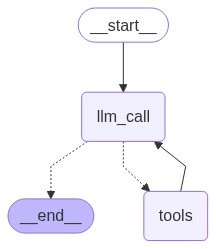

In [ ]:
rag_prompt = """
You are a helpful medical research assistant tasked with retrieving information from PubMed articles. 
Always clarify the user's research question or scope before retrieving. 
Use the retrieval tool to gather relevant PubMed abstracts, metadata, and references. 
Reflect on the retrieved context, prioritize citing references, and synthesize findings into accurate, evidence-based responses. 
If more context is needed, continue retrieving until you have sufficient coverage to answer the user's request thoroughly.
"""


class State(MessagesState):
    texts: str


def llm_call(state: State):
    messages = state.get("messages", [])

    # If no messages yet, start the conversation
    if not messages:
        messages = [
            SystemMessage(content=rag_prompt),
            HumanMessage(content=state["texts"]),
        ]

    response = llm_with_tools.invoke(messages)
    return {"messages": messages + [response]}


# state = State(texts="What are the approaches to Task Decomposition?")
graph = StateGraph(State)
graph.add_node("llm_call", llm_call)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("llm_call")
graph.add_conditional_edges(
    "llm_call", tools_condition, {"tools": "tools", "__end__": END}
)
graph.add_edge("tools", "llm_call")

full_graph = graph.compile()
full_graph

In [ ]:
state = State(texts="What are the applications of AI in medicine according to PubMed?")
result = full_graph.invoke(state)

print(result["messages"][-1].content)  # Final assistant answer

Based on my search of PubMed literature, here's a comprehensive overview of the applications of artificial intelligence in medicine:

## Major Applications of AI in Medicine According to PubMed Research

### 1. **Medical Imaging and Diagnostics**
- **Radiology**: AI algorithms significantly improve accuracy and efficiency in interpreting X-rays, CT scans, and MRIs
- **Pathology**: Automated analysis of tissue samples and digital pathology images
- **Cardiology**: Coronary calcium scoring and early detection of cardiovascular abnormalities
- **Breast Cancer Screening**: Enhanced detection in mammography, ultrasound, and MRI
- **Ophthalmology**: Retinal image analysis for early eye disease detection
- **Nuclear Medicine**: AI-assisted image generation and interpretation

### 2. **Clinical Decision Support Systems**
- **Diagnostic Assistance**: AI tools that help physicians interpret complex medical data
- **Treatment Planning**: Personalized treatment recommendations based on patient dat